In [0]:
import torch
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
from google.colab import files
import os
files.upload()
os.system("mkdir -p ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

0

In [0]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

100% 786M/788M [00:08<00:00, 120MB/s]
100% 788M/788M [00:08<00:00, 97.7MB/s]


In [0]:
!unzip /content/microsoft-catsvsdogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [0]:
#Testing and training data
import glob
import cv2
all_files = glob.glob('/content/PetImages/*/*.jpg')
for path in all_files:
  img = cv2.imread(path)
  try:
    img += 1
  except:
    all_files.remove(path)
train_split = all_files[:int(0.9*len(all_files))]
test_split = all_files[int(0.9*len(all_files)):]

In [0]:
import os
classes = os.listdir('/content/PetImages/')
encoder = {}
decoder = {}
for idx,cl in enumerate(classes):
  encoder[cl] = idx
  decoder[idx] = cl

In [0]:
import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import cv2
class intel_dataset(Dataset):
    def __init__(self,files,encoder,transform):
      self.files = files
      self.encoder = encoder
      self.transform = transform
    def __len__(self):
      return len(self.files)
    def __getitem__(self,idx):
      image_path = self.files[idx]
      image = cv2.imread(image_path)
      if(self.transform):
        image = self.transform(image)
      label = image_path.split('/')[-2]
      return image,self.encoder[label],image_path
im_size = 224
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [0]:
train_dataset = intel_dataset(train_split,encoder,train_transforms)
test_dataset = intel_dataset(test_split,encoder,train_transforms)
train_loader = DataLoader(train_dataset, shuffle = True, batch_size = 8)
test_loader = DataLoader(test_dataset,batch_size = 8)

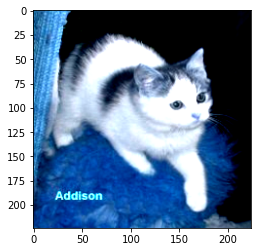

In [0]:
image,label,_ = train_dataset[0]
import numpy as np
def im_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0, 1)
    return image


import matplotlib.pyplot as plt
plt.imshow(im_convert(image))

In [0]:
from torch import nn
from torchvision import models
class PAM_Module(nn.Module):
    """ Position attention module"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out

class classifie(nn.Module):
    def __init__(self, n_classes, pretrained = True ):
        super(classifie, self).__init__()
        cnn_arch = models.resnet34(pretrained=True)
        cnn_arch = nn.Sequential(*list(cnn_arch.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.cnn_arch = cnn_arch
        self.linear1 = nn.Linear(512,2)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.4)
        self.attention = PAM_Module(512)
    def forward(self, input):
        am = self.cnn_arch(input)
#        am = self.pool(am)
        am = self.pool(self.attention(am))
        x = self.dropout(self.linear1(am.view(-1,512)))
        return x

In [0]:
model = classifie(6).cuda()
model(torch.zeros(1,3,150,150).cuda())

tensor([[-1.2022,  0.0000]], device='cuda:0', grad_fn=<FusedDropoutBackward>)

In [0]:
!pip install wandb

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 460kB 60.0MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 112kB 59.7MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=5ee4102fe10a546a45f639f7f5c30c57b9f64f29c2ba767bfe2700dd946517d9
  Stored in directory: /root/.cache/pip/wheels/bc/ed/6c/028dea90d31b359cd2a7c8b0da4db80e41d24a59614154072e
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=cf84ce899e3f8f2421a67f99cf300519fdee048ee678cf88ee27cf010211f5e2
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=4

In [0]:
import wandb
params = {
          'batch_size': 32,
          'criterion' : 'nn.CrossEntropyLoss().cuda()',
          'dropout':0.7,
          'activation': 'relu'
          }
wandb.init(name = 'Captum Images',project="PIPELINE Final",config = params)

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


KeyboardInterrupt: ignored

In [0]:
wrong_image_path = {}
pred_label_idx=[]

In [0]:
def wrongly_predicted_images(inputs,outputs,targets,path):
  outputs=outputs.detach().argmax(1)
  temp_output = outputs.cpu().numpy()
  temp_target = targets.cpu().numpy()
  #fig = plt.figure(figsize=(35, 4))
  for i in range(len(temp_output)):
    if temp_output[i]!=temp_target[i]:
      wrong_image_path[path[i]]=(temp_output[i],temp_target[i])

In [0]:
import time
import sys

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(model,epoch,data_loader,call_now):
    print('Training Epoch {}'.format(epoch))
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracies = AverageMeter()
    start_time = time.time()
    end_time = time.time()
    t = []
    batch_size= 16
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
    for i, (inputs, targets, path) in enumerate(data_loader):
        data_time.update(time.time() - end_time)
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.cuda.LongTensor))
        acc = 100 * (outputs.detach().argmax(1) == targets).cpu().numpy().mean()
        _,pred_label_idx = torch.topk(outputs, 1)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if call_now == 1 : 
        #   wrongly_predicted_images(inputs,outputs,targets,path)

        batch_time.update(time.time() - end_time)
        end_time = time.time()
        sys.stdout.write(
                "\r[Epoch %d] [Batch %d / %d] [Time %.2f %.2f] [Data %.2f %.2f] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    i,
                    len(data_loader),
                    batch_time.val,
                    batch_time.avg,
                    data_time.val,
                    data_time.avg,
                    losses.avg,
                    accuracies.avg))
        
    return losses.avg, accuracies.avg  

Training Epoch 0
[Epoch 0] [Batch 2806 / 2807] [Time 0.04 0.07] [Data 0.02 0.04] [Loss: 0.695500, Acc: 57.56%]

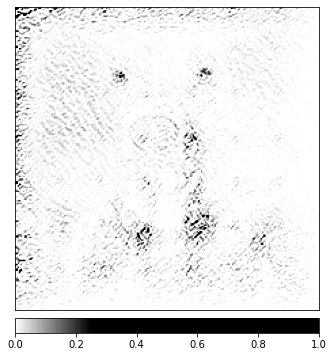

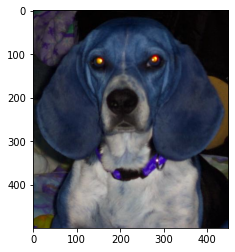

Training Epoch 1
[Epoch 1] [Batch 2806 / 2807] [Time 0.04 0.07] [Data 0.02 0.04] [Loss: 0.655807, Acc: 60.25%]

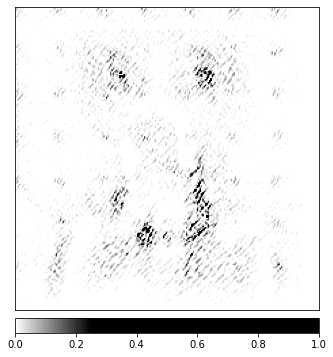

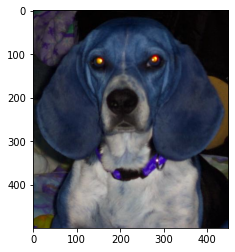

Training Epoch 2
[Epoch 2] [Batch 2806 / 2807] [Time 0.05 0.07] [Data 0.01 0.04] [Loss: 0.636532, Acc: 62.76%]

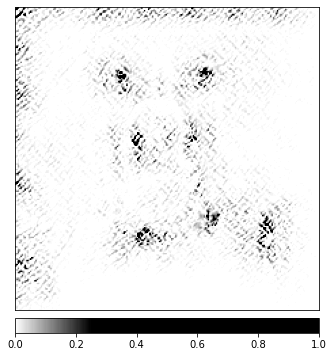

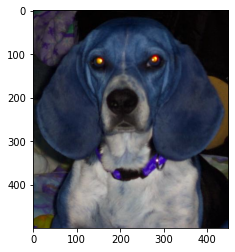

Training Epoch 3
[Epoch 3] [Batch 2806 / 2807] [Time 0.05 0.07] [Data 0.03 0.04] [Loss: 0.584520, Acc: 67.66%]

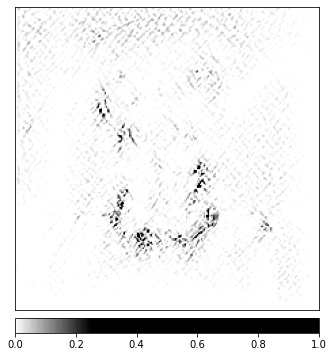

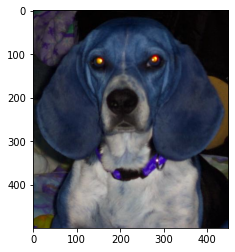

Training Epoch 4
[Epoch 4] [Batch 2806 / 2807] [Time 0.04 0.07] [Data 0.02 0.04] [Loss: 0.519533, Acc: 72.04%]

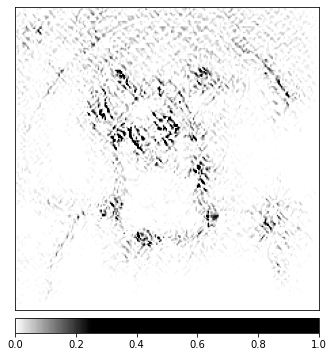

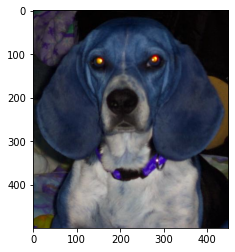

Training Epoch 5
[Epoch 5] [Batch 2806 / 2807] [Time 0.04 0.07] [Data 0.01 0.04] [Loss: 0.428149, Acc: 77.66%]

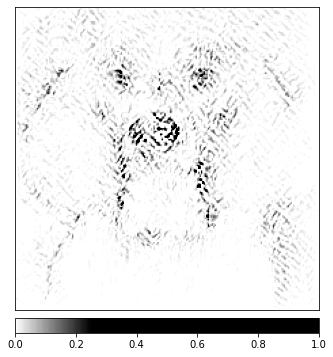

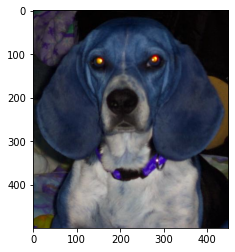

Training Epoch 6
[Epoch 6] [Batch 2806 / 2807] [Time 0.04 0.07] [Data 0.02 0.04] [Loss: 0.351981, Acc: 81.18%]

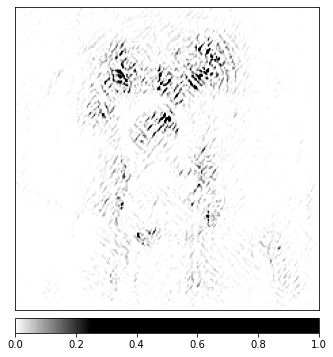

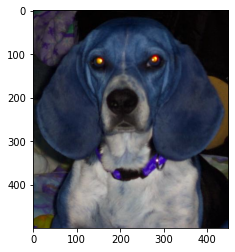

Training Epoch 7
[Epoch 7] [Batch 2806 / 2807] [Time 0.04 0.07] [Data 0.01 0.04] [Loss: 0.302483, Acc: 83.81%]

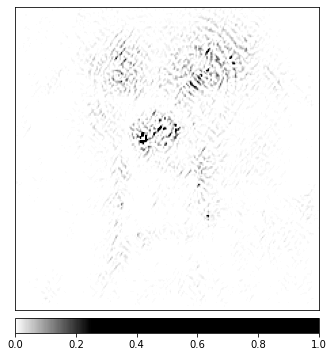

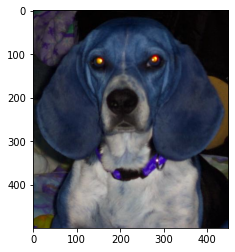

Training Epoch 8
[Epoch 8] [Batch 2806 / 2807] [Time 0.04 0.07] [Data 0.02 0.04] [Loss: 0.281843, Acc: 84.51%]

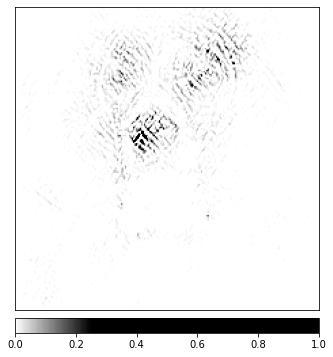

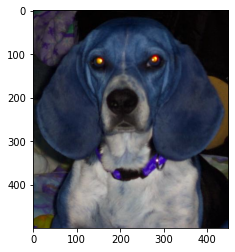

Training Epoch 9
[Epoch 9] [Batch 2806 / 2807] [Time 0.04 0.07] [Data 0.02 0.04] [Loss: 0.258852, Acc: 85.33%]

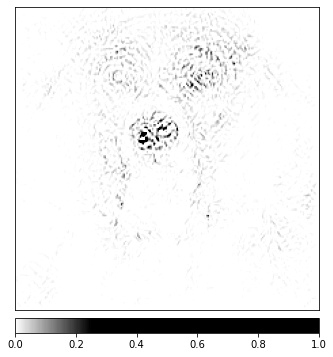

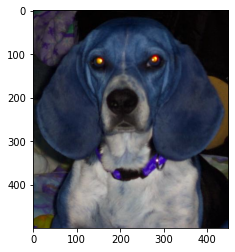

In [0]:
call_now = 0
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms


from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import NoiseTunnel,GuidedGradCam
from captum.attr import visualization as viz
idx = 300

for epoch in range(10):
  model.train()
  value = train_epoch(model, epoch, train_loader,call_now)
  model.eval()
  ig = IntegratedGradients(model)
  noise_tunnel = ig
  attributions = noise_tunnel.attribute(train_transforms(cv2.imread(test_split[idx])).unsqueeze(0).cuda(), target = 1)
  default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                  [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=256)

  _ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                              cv2.imread(test_split[idx]),
                              method='heat_map',
                              cmap=default_cmap,
                              show_colorbar=True,
                              sign='positive',
                              outlier_perc=1)
  plt.imshow(cv2.imread(test_split[idx]))
  plt.show()
      # print("Epoch Loss = ",value[0], "    Epoch Accuracy = ",value[1])
      # wandb.log({'epoch': epoch, 'loss': value[0], 'accuracy': value[1]})
      # if value[1] > 81 : 
      #   call_now=1

In [0]:
import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

idx = 1001
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import NoiseTunnel,GuidedGradCam
from captum.attr import visualization as viz

model.eval()
ig = IntegratedGradients(model)
noise_tunnel = ig
attributions = noise_tunnel.attribute(train_transforms(cv2.imread(test_split[idx])).unsqueeze(0).cuda(), target = 1)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N = 256)

_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                            cv2.imread(test_split[idx]),
                            method='heat_map',
                            cmap=default_cmap,
                            show_colorbar=True,
                            sign='positive',
                            outlier_perc=1)
plt.imshow(cv2.imread(test_split[idx]))
plt.show()

In [0]:
#Pushes images on wandb
for i in range(len(wrong_image_path)):
  wandb.log({"Wrong train images" + str(i) + "     Predicted Label - " + classes[wrong_image_path[i][1]] + "  Correct Label - " + classes[wrong_image_path[i][2]]: [wandb.Image(cv2.imread(wrong_image_path[i][0]) )]  })

{'ss': (3, 4), 'sa': (2, 2)}


In [0]:
pip install captum

     |████████████████████████████████| 1.4MB 4.8MB/s 


In [0]:
def GradientShapCaptum(model,image,pred_label):
  torch.manual_seed(0)
  np.random.seed(0)

  gradient_shap = GradientShap(model)

  # Defining baseline distribution of images
  rand_img_dist = torch.cat([x * 0, x * 1])

  attributions_gs = gradient_shap.attribute(image,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label)
  d = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
  return d[0]

In [0]:
def GradientDisplay(d):
  for img in d.keys():
    image = torch.Tensor(cv2.imread(img))
    pred_label=torch.IntTensor(d[img][0])
    image=image.unsqueeze(0)
    pred_label.squeeze_()
    wandb.log({"GradientShapCaptum": [wandb.Image(   GradientShapCaptum(model,image,pred_label)   )   ]  })

In [0]:
GradientDisplay(wrong_image_path)

In [0]:
def NoiseChannelCaptum(model,image,pred_label):
  noise_tunnel = NoiseTunnel(integrated_gradients)

  attributions_ig_nt = noise_tunnel.attribute(image, n_samples=10, nt_type='smoothgrad_sq', target=pred_label)
  d = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
  return d[0]

In [0]:
model.cnn_arch[7]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [0]:
encoder

{'Cat': 0, 'Dog': 1}

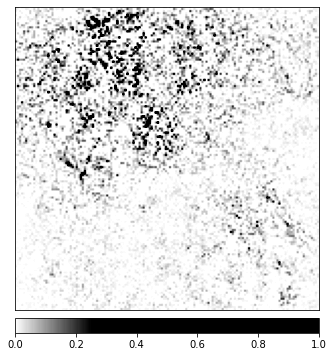

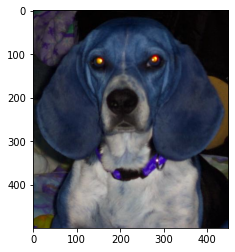

In [0]:
idx = 300
ig = IntegratedGradients(model)
noise_tunnel = NoiseTunnel(ig)
attributions = noise_tunnel.attribute(train_transforms(cv2.imread(test_split[idx])).unsqueeze(0).cuda(), target = 1)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             cv2.imread(test_split[idx]),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
plt.imshow(cv2.imread(test_split[idx]))

In [0]:
def NoiseTunnelDisplay(d):
  for img in d.keys():
    image = torch.Tensor(cv2.imread(img))
    pred_label=torch.IntTensor(d[img][0])
    image=image.unsqueeze(0)
    pred_label.squeeze_()
    
    plt.imshow()
#    wandb.log({"NoiseTunnelCaptum": [wandb.Image(   NoiseTunnelCaptum(model,image,pred_label)   )   ]  })

In [0]:
NoiseTunnelDisplay(wrong_image_path)